<a href="https://colab.research.google.com/github/lauxpaux/Cali_HousingPrediction/blob/main/Cali_housing_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Predictions

This project is a part of the [handson-ml2 ](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)book.

In this project we analyze the efficacy different predictive models. The models are trained using a California housing prices dataset in order to predict the median housing value in different districts. 


###Technologies used:

*   Python
* Pandas
* Numpy
* Sklearn
* Matplotlib

### Models selected for comparison:
* Linear regression
* Random forest
* Support vector machine with linear kernel
* Linear stochastic gradient descent





Let's start by retrieving and looking at the data to get familiar with the different features. From .describe() and .info(), we can see see the different datatypes in the dataset, and gauge insight into the ranges for different features.

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import seaborn as sns
import matplotlib as plt

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
IMG_PATH = Path() /'images'/'housing_predictions'
IMG_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMG_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

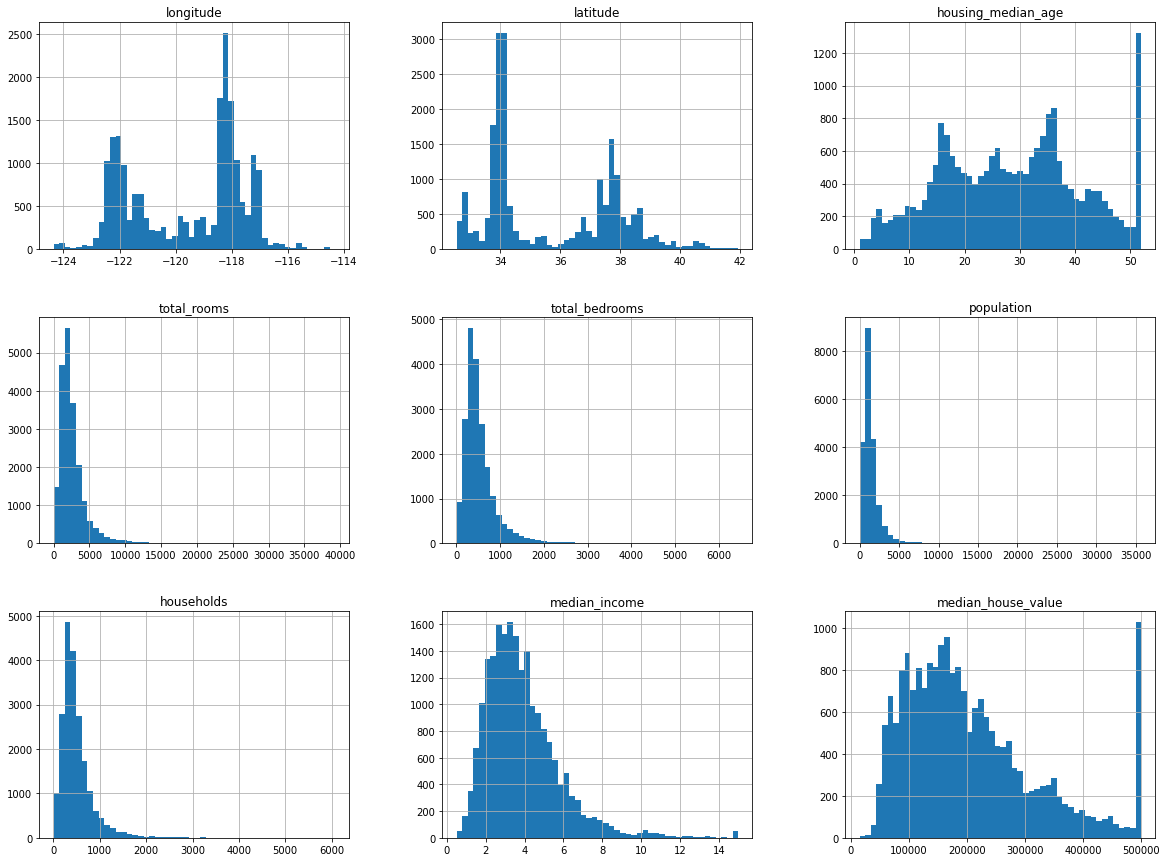

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

## Creating a test set
Doing this first to avoid snoop bias

In [ ]:
import numpy as np 

In [ ]:
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print('Train set: ' , len(train_set))
print('Test set: ', len(test_set))

Train set:  16512
Test set:  4128


In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

Housing data does not have ID so we will add index column to use as ID. The downside to this is that data is appended to the dataset it should only be appended at the end and no rows should be deleted. If this is impossible, try to create an ID around the most stable features. In this project it is recommended to use latitude and longitude.

In [ ]:
housing_with_id = housing.reset_index() #adding index column to use as ID
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Use latitude and longitude to create ID

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Creating an income category based on median_income. Then performing stratified sampling using sklearn

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

## Exploratory Data Analysis 

Perform data exploration on the train set. If the train set is too large you can sample the train set to make exploration faster and more manageable.

In [ ]:
#make a copy of train set to avoid altering it 

housing = strat_train_set.copy()

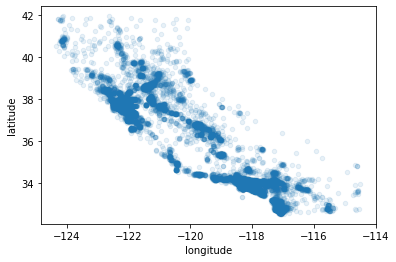

In [ ]:
#set alpha=0.1 to visualize density better 
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

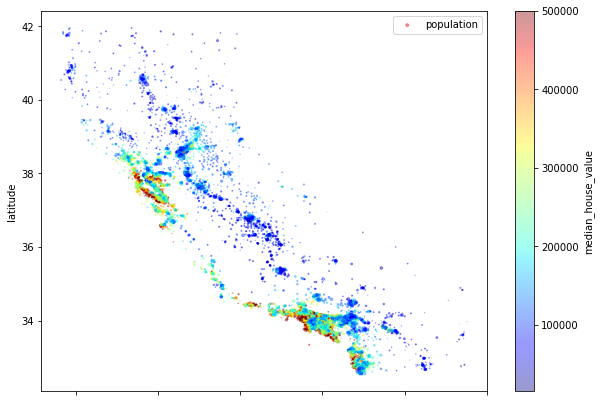

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/1000, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

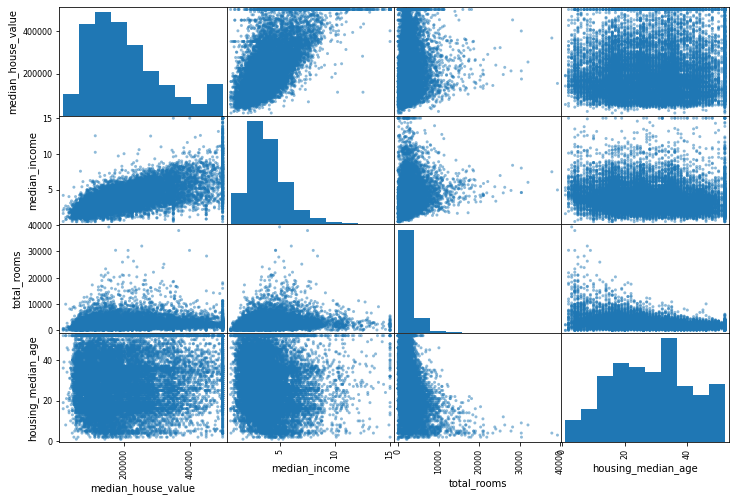

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

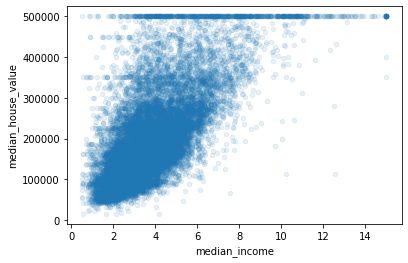

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

Make consice features out of available features to gather further insight

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] /housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

Copy data to start with trained set, and remove labels 

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# housing.dropna(subset=["total_bedrooms"])
# housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

Using Simple Imputer to calculate median on numerical values

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Saving transformed training set with transformed missing values with learned median to variable X, which will be used later

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Working with categorical data

Transforming categorical values to numerical values using Scikit-Learn's OrdinalEncoder class

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10) 

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [ ]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

Performing One-hot encoding to "turn on" (1) a single attribute while keeping the other attributes "off/cold" at (0).

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Automating hyperparameter tuning using custom transformer

Example of custom transformer for housing data set. Knowing to write custom transformers is important to relieve time and effort when creating hypermaters or analyzing whether adding an attribute to a machine learning algorithm helps or not. The more automation the faster you will find a good combination of attributes for the model.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self #all done
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
                   bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household] 

  ## create transformer to drop unimportant features 
  def drop_features(self, X, y=None):
    important_features = X['NEAR OCEAN'], X['NEAR BAY'], X['IN LAND'].drop()
    return important_features

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling
It is hard or impossible to create a good model when all data attributes have different scales. There are several ways to tackle feature scaling:



*   Min-max scaling: normalization, features scales from 0-1 by subtracting the min value and dividing by the max minus the min. Sci-kit learn uses MinMaxScaler.

*   Standardization subtracts the mean value and divides it by the standard deviation (standardized values have a zero mean. It does not bound the resulting values to a specific range. It does better at handling outliers. Scikit-Learn uses StandardScaler.

*Fit scalers to training data only*



## Transformation Pipelines

Used to maintain proper order of data transformation steps. Scikit-Learn has a Pipeline class to aid in sequence. All steps must be transformers (fit transform methods) with the exception of the last one. Below is an example of a transformation pipeline for numerical attributes.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Scikit-Learn uses ColumnTransformer to transform all columns regardless if they are numerical or categorical. We can use that to apply all transformation instead of doing the transformations separately as we have been.

In [ ]:
from sklearn.compose import ColumnTransformer 

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Training and evaluating models

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
linear_mdl = lin_reg.fit(housing_prepared, housing_labels)

Selecting a few instances from the training set 

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]
Labels: [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


Creating mean squared error for evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67769.12117461127

Trying out Decision Tree Regression model. A more complex model that can find nonlinear relationships in the data.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Decision tree regressor resulted in an root mean squared error of 0. This is a positive indication that the model overfit the training set. We don't want to touch the test set until we've built a solid model so we will use part of the training set as a validation set. 

Evaluating model performance using K-fold Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scores for Decision Tree model

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [67470.71244218 66502.11125499 68636.06481388 72664.89127843
 68345.23150846 68295.34176919 71571.01462117 72653.26419023
 69062.60936651 69352.09472981]
Mean: 69455.33359748735
Standard deviation: 2026.7799517113847


# Model Selection: 1 Linear Regression
Scores for the linear regression model

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
Mean: 67994.06678091262
Standard deviation: 1394.937701550329


# Model selection 2: Random Forest 
Trying out RandomForrestRegressor (Ensemble Learning). Training set

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
random_forest_mdl = forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48825.51625514 49606.44064465 47703.90549603 50242.77031709
 49089.40866737 49498.66541085 50277.27788087 51515.11693129
 50229.54402647 50021.4220157 ]
Mean: 49701.00676454522
Standard deviation: 973.5216242885141


Trying Support Vector Machine

# Model Selection 3: Support Vector Machine with linear kernel

Support Vector Machine with linear kernel

In [ ]:
from sklearn import svm

svm_lnr = svm.SVR(kernel='linear')
svm_lnr_mdl = svm_lnr.fit(housing_prepared, housing_labels)

In [ ]:
svm_lnr_scores = cross_val_score(svm_lnr, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
svm_lnr_rmse_scores = np.sqrt(-svm_lnr_scores)
display_scores(svm_lnr_rmse_scores)

Scores: [113538.27487704 114028.34921524 109143.71508685 110279.16743333
 110609.80770625 112580.84267984 111629.7093742  109110.11026557
 108699.61055577 113288.52897014]
Mean: 111290.81161642264
Standard deviation: 1894.2572364204802


# Model Selection 4: Linear Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd_model = sgd.fit(housing_prepared, housing_labels)

In [ ]:
sgd_scores = cross_val_score(sgd, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)
display_scores(sgd_rmse_scores)

Scores: [2.58921770e+06 2.49151356e+06 7.42823128e+05 7.07756215e+04
 2.86143979e+06 6.67020993e+06 3.50856508e+06 3.18703516e+08
 2.01435840e+06 7.66670138e+06]
Mean: 34731912.05242275
Standard deviation: 94683772.58868846


## Worse performing models 

Support Vector Regression

In [ ]:
from sklearn import svm

svr_reg = svm.SVR()
svr_mdl = svr_reg.fit(housing_prepared, housing_labels)

In [ ]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [120038.84749392 121456.76501041 115769.69830984 117350.80616306
 117323.69195091 119649.74312751 118679.56023902 115737.83301587
 114889.85486998 120332.4929416 ]
Mean: 118122.92931221137
Standard deviation: 2126.557738427293


Trying out LinearSVR 

In [ ]:
from sklearn.svm import LinearSVR

lnr_svr = svm.LinearSVR()
lnr_svr_mdl = lnr_svr.fit(housing_prepared, housing_labels)               

In [ ]:
lnr_svr_scores = cross_val_score(lnr_svr, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
lnr_svr_rmse_scores = np.sqrt(-lnr_svr_scores)
display_scores(lnr_svr_rmse_scores)

Scores: [218971.50009448 222036.28557965 215976.3559937  219851.56607414
 219942.7741445  222958.12326562 217725.82982158 216893.41322545
 218376.68529671 221578.81350707]
Mean: 219431.13470029124
Standard deviation: 2165.2768784290715


## Fine tuning models

## Grid Search:
We'll be using Grid Search to find the best combination of features for our prediction outcomes. Better when the search space is smaller, with fewer combinations


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'n_estimators': [30, 60, 90], 'max_features': [5, 6, 8, 10]},
    {'n_estimators': [80, 90, 100], 'max_features': [5, 6, 8, 10]},
    {'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'max_features': [5, 6, 8, 10],
                          'n_estimators': [30, 60, 90]},
                         {'max_features': [5, 6, 8, 10],
                          'n_estimators': [80, 90, 100]},
                         {'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 100}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

62257.61840441488 {'max_features': 2, 'n_estimators': 3}
55112.23651284663 {'max_features': 2, 'n_estimators': 10}
52203.030977033064 {'max_features': 2, 'n_estimators': 30}
60308.431771445205 {'max_features': 4, 'n_estimators': 3}
52929.71897999125 {'max_features': 4, 'n_estimators': 10}
50242.00267742475 {'max_features': 4, 'n_estimators': 30}
58352.71208904189 {'max_features': 6, 'n_estimators': 3}
51660.89572968252 {'max_features': 6, 'n_estimators': 10}
49774.63830460848 {'max_features': 6, 'n_estimators': 30}
58417.94570102829 {'max_features': 8, 'n_estimators': 3}
51609.92287244127 {'max_features': 8, 'n_estimators': 10}
49579.526089698156 {'max_features': 8, 'n_estimators': 30}
49658.948637960566 {'max_features': 5, 'n_estimators': 30}
49159.63211615171 {'max_features': 5, 'n_estimators': 60}
48925.287328996776 {'max_features': 5, 'n_estimators': 90}
49709.33241345776 {'max_features': 6, 'n_estimators': 30}
49093.42221260293 {'max_features': 6, 'n_estimators': 60}
48963.4374348

## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'n_estimators': [30, 60, 90], 'max_features': [5, 6, 8, 10]},
    {'n_estimators': [80, 90, 100], 'max_features': [5, 6, 8, 10]},
    {'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg_randm = RandomForestRegressor()

random_search = RandomizedSearchCV(forest_reg_randm, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)

random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'max_features': [5, 6, 8, 10],
                                         'n_estimators': [30, 60, 90]},
                                        {'max_features': [5, 6, 8, 10],
                                         'n_estimators': [80, 90, 100]},
                                        {'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
random_search.best_params_

{'n_estimators': 90, 'max_features': 5}

In [ ]:
random_search.best_estimator_

RandomForestRegressor(max_features=5, n_estimators=90)

In [ ]:
ran_cvres = random_search.cv_results_
for mean_score, params in zip(ran_cvres["mean_test_score"], ran_cvres["params"]):
  print(np.sqrt(-mean_score), params)

52965.48036105807 {'n_estimators': 10, 'max_features': 4}
59504.9921286968 {'n_estimators': 3, 'max_features': 4}
58399.01658192446 {'n_estimators': 3, 'max_features': 8}
48871.47095755927 {'n_estimators': 90, 'max_features': 5}
49356.77145493865 {'n_estimators': 30, 'max_features': 6}
49102.81239736723 {'n_estimators': 100, 'max_features': 8}
49146.50220321633 {'n_estimators': 80, 'max_features': 8}
49296.40427240953 {'n_estimators': 90, 'max_features': 10}
53188.805718231604 {'n_estimators': 10, 'max_features': 3}
49886.67694276224 {'n_estimators': 30, 'max_features': 8}


## Using ensemble methods
Combination of all good models used together 

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [ ]:
feature_importances

array([7.69653875e-02, 7.31270392e-02, 4.26651010e-02, 1.71730302e-02,
       1.60989772e-02, 1.71586690e-02, 1.60583451e-02, 2.98314646e-01,
       7.06605265e-02, 1.12523589e-01, 8.61418921e-02, 1.19010622e-02,
       1.52163014e-01, 1.20749028e-04, 3.46303205e-03, 5.46493876e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29831464639065014, 'median_income'),
 (0.15216301445755945, 'INLAND'),
 (0.11252358941537827, 'pop_per_hhold'),
 (0.08614189207324623, 'bedrooms_per_room'),
 (0.07696538745555793, 'longitude'),
 (0.07312703918710028, 'latitude'),
 (0.07066052652845758, 'rooms_per_hhold'),
 (0.042665100978084534, 'housing_median_age'),
 (0.017173030206437286, 'total_rooms'),
 (0.01715866902734721, 'population'),
 (0.016098977152314356, 'total_bedrooms'),
 (0.01605834511505917, 'households'),
 (0.011901062168530785, '<1H OCEAN'),
 (0.005464938760912916, 'NEAR OCEAN'),
 (0.003463032054958007, 'NEAR BAY'),
 (0.00012074902840586747, 'ISLAND')]

From here you could drop some of the least useful features to further enhance/simplify the model

## Fitting the final model with the best features 

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

#transform not fit transform
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48997.48045122979


Computing with 95% confidence 

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1 ,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46681.87157482, 51208.48608785])

In [ ]:
print(squared_errors)

3905     3.338006e+08
16821    9.026900e+07
2900     3.785838e+09
7193     1.740552e+08
13928    5.257422e+09
             ...     
12369    2.954961e+06
8707     1.982464e+06
16634    5.250509e+08
9779     7.071876e+08
3455     5.907925e+09
Name: median_house_value, Length: 4128, dtype: float64


From our models, we learned that the biggest determinant of the 'median_housing_price' were 'median_income' and whether the home were in the 'INLAND' category of the 'ocean proximity' feature. 

This model performed decently based on the final features we selected, but given how outdated the data is this should not be deployed. The biggest change I would make in the future is using updated data.